In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from tqdm import tqdm
import json

In [2]:
# Load the variables
with open('./utils/variables.json', 'r') as file:
    variables = json.load(file)

SCR_feature_space = variables['SCR_feature_space']
LAB_feature_space = variables['LAB_feature_space']
train_len = variables['train_len']
test_len = variables['test_len']
print(len(SCR_feature_space), len(LAB_feature_space))
print(train_len, test_len)

# get num_processors for parallel computing
num_processors = multiprocessing.cpu_count()

7 40
8637 8542


In [ ]:
figure_folder = "Imputation_3"

# Process Dataset

In [3]:
# read onset dadaset
dataset = pd.read_csv("/blue/yonghui.wu/lideyi/Personalization_Methodology/dataset.csv")
# make sure the index is ordered
dataset = dataset.reset_index(drop=True)
assert len(dataset) == train_len + test_len

In [4]:
# split the dataset into train and test
data_train = dataset.iloc[:train_len, :].copy(deep = True)
data_test = dataset.iloc[train_len:, :].copy(deep = True)

# Run DTW with Missing Values

Since DTW-AROW does not require missing data imputation, we run it first. Then we impute the data and run normalization.

In [5]:
from utils.Distance_Computing import parallel_distance_matrix
from utils.Z_Helping_Functions import translate_dist_mtx_to_simi, fast_argsort

In [6]:
# for SCR we do not apply the same normalization as SCR, since the values are already in the same range (unit)
SCR_full = dataset.loc[:, SCR_feature_space].copy(deep = True)

In [7]:
# SCR_DTW_dist_full = parallel_distance_matrix(SCR_full, num_processors, get_DTW_distance)
# np.save('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_DTW_dist_imput2.npy', SCR_DTW_dist_full)

In [8]:
SCR_DTW_dist_full = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_DTW_dist_imput2.npy')

In [9]:
# transfrom distance mtx to similarity score mtx by min-max normalization and substration from 1
SCR_DTW_simi_full = translate_dist_mtx_to_simi(SCR_DTW_dist_full)
# sort similarity score mtx into idx matrix by most similar rank highest. This is for the entire dataset, train + test
SCR_DTW_idx_full = fast_argsort(SCR_DTW_simi_full, num_processors)

In [10]:
# get the similarity matrix and idx rankings only for train set, this is for the one-vs-all training
SCR_DTW_dist_train = SCR_DTW_dist_full[:len(data_train), :len(data_train)]
SCR_DTW_simi_train = translate_dist_mtx_to_simi(SCR_DTW_dist_train)
SCR_DTW_idx_train = fast_argsort(SCR_DTW_simi_train, num_processors)

# Impute Missing Values in LAB and LAB

In [11]:
from sklearn.impute import KNNImputer

LAB: KNN imputer

In [12]:
# after imputation, we can safely split into train and test
SCR_train = SCR_full.iloc[:train_len, :].copy(deep = True)
SCR_test = SCR_full.iloc[train_len:, :].copy(deep = True)

In [13]:
n_neighbors_imputer = 5
# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=n_neighbors_imputer, weights="uniform")

# Fit the imputer on the train data (train only to avoid data leakage)
knn_imputer.fit(SCR_train)

# Impute missing values in train and test datasets
SCR_train = pd.DataFrame(knn_imputer.transform(SCR_train), columns=SCR_train.columns)
SCR_test = pd.DataFrame(knn_imputer.transform(SCR_test), columns=SCR_test.columns)
SCR_full = pd.concat([SCR_train, SCR_test], axis = 0)

LAB: KNN imputer

In [14]:
# it is of note that the imputation is done on the lab train and lab test separately
# this is to avoid data leakage
LAB_train = data_train.loc[:, LAB_feature_space].copy(deep = True)
LAB_test = data_test.loc[:, LAB_feature_space].copy(deep = True)

In [15]:
# lab normalization
LAB_train = (LAB_train - LAB_train.min(skipna=True)) / (LAB_train.max(skipna=True) - LAB_train.min(skipna=True))
LAB_test = (LAB_test - LAB_test.min(skipna=True)) / (LAB_test.max(skipna=True) - LAB_test.min(skipna=True))
# Initialize KNNImputer
knn_imputer = KNNImputer(n_neighbors=n_neighbors_imputer, weights="uniform")
# Fit the imputer on the train data (train only to avoid data leakage)
knn_imputer.fit(LAB_train)
# Impute missing values in train and test datasets
LAB_train = pd.DataFrame(knn_imputer.transform(LAB_train), columns=LAB_train.columns)
LAB_test = pd.DataFrame(knn_imputer.transform(LAB_test), columns=LAB_test.columns)
# Concate train and test
LAB_full = pd.concat([LAB_train, LAB_test], axis = 0)

# Compute Euclidean, Cosine and Manhattan Matrix of LAB and LAB

In [16]:
from utils.Distance_Computing import compute_similarity

In [17]:
# SCR
# Euclidean
SCR_Euc_simi_full, SCR_Euc_idx_full, SCR_Euc_simi_train, SCR_Euc_idx_train = compute_similarity(SCR_full, 'euclidean', train_len, num_processors)
# Cosine
SCR_Cos_simi_full, SCR_Cos_idx_full, SCR_Cos_simi_train, SCR_Cos_idx_train = compute_similarity(SCR_full, 'cosine', train_len, num_processors)
# Manhattan
SCR_Manh_simi_full, SCR_Manh_idx_full, SCR_Manh_simi_train, SCR_Manh_idx_train = compute_similarity(SCR_full, 'manhattan', train_len, num_processors)

In [18]:
# LAB
# Euclidean
LAB_Euc_simi_full, LAB_Euc_idx_full, LAB_Euc_simi_train, LAB_Euc_idx_train = compute_similarity(LAB_full, 'euclidean', train_len, num_processors)
# Cosine
LAB_Cos_simi_full, LAB_Cos_idx_full, LAB_Cos_simi_train, LAB_Cos_idx_train = compute_similarity(LAB_full, 'cosine', train_len, num_processors)
# Manhattan
LAB_Manh_simi_full, LAB_Manh_idx_full, LAB_Manh_simi_train, LAB_Manh_idx_train = compute_similarity(LAB_full, 'manhattan', train_len, num_processors)

In [19]:
# simi here is the un-ordered, normalized similarity score matrix, idx is the ordered paitent index matrix
# nw stands for not weighted by data overlap rates matrix
nw_fea_arrs_dict = {"SCR": {"DTW": {"simi": {"full": SCR_DTW_simi_full, "train": SCR_DTW_simi_train}, "idx": {"full": SCR_DTW_idx_full, "train": SCR_DTW_idx_train}}, 
                            "Euc": {"simi": {"full": SCR_Euc_simi_full, "train": SCR_Euc_simi_train}, "idx": {"full": SCR_Euc_idx_full, "train": SCR_Euc_idx_train}}, 
                            "Cos": {"simi": {"full": SCR_Cos_simi_full, "train": SCR_Cos_simi_train}, "idx": {"full": SCR_Cos_idx_full, "train": SCR_Cos_idx_train}}, 
                            "Manh":{"simi": {"full": SCR_Manh_simi_full, "train": SCR_Manh_simi_train}, "idx": {"full": SCR_Manh_idx_full, "train": SCR_Manh_idx_train}}}, 
                    "LAB": {"Euc": {"simi": {"full": LAB_Euc_simi_full, "train": LAB_Euc_simi_train}, "idx": {"full": LAB_Euc_idx_full, "train": LAB_Euc_idx_train}}, 
                            "Cos": {"simi": {"full": LAB_Cos_simi_full, "train": LAB_Cos_simi_train}, "idx": {"full": LAB_Cos_idx_full, "train": LAB_Cos_idx_train}}, 
                            "Manh":{"simi": {"full": LAB_Manh_simi_full, "train": LAB_Manh_simi_train}, "idx": {"full": LAB_Manh_idx_full, "train": LAB_Manh_idx_train}}}}

# Data Overlap Rates Weighting

In [20]:
# read pre-computed pairwise data overlap rates
SCR_overlap_full = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/SCR_overlap.npy')
LAB_overlap_full = np.load('/blue/yonghui.wu/lideyi/Personalization_Methodology/lab_overlap.npy')

In [21]:
# consequently, we will only use the upper-left block of the overlap rate mtx for one-vs-all training
SCR_overlap_train = SCR_overlap_full[:train_len, :train_len]
LAB_overlap_train = LAB_overlap_full[:train_len, :train_len]

In [22]:
from utils.Distance_Computing import overlap_rates_weighting

In [23]:
# on full data (for testing)
# SCR
SCR_DTW_simi_wt_full, SCR_DTW_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["DTW"]["simi"]["full"], num_processors)
SCR_Euc_simi_wt_full, SCR_Euc_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["Euc"]["simi"]["full"], num_processors)
SCR_Cos_simi_wt_full, SCR_Cos_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["Cos"]["simi"]["full"], num_processors)
SCR_Manh_simi_wt_full, SCR_Manh_idx_wt_full = overlap_rates_weighting(SCR_overlap_full, nw_fea_arrs_dict["SCR"]["Manh"]["simi"]["full"], num_processors)

In [24]:
# LAB
LAB_Euc_simi_wt_full, LAB_Euc_idx_wt_full = overlap_rates_weighting(LAB_overlap_full, nw_fea_arrs_dict["LAB"]["Euc"]["simi"]["full"], num_processors)
LAB_Cos_simi_wt_full, LAB_Cos_idx_wt_full = overlap_rates_weighting(LAB_overlap_full, nw_fea_arrs_dict["LAB"]["Cos"]["simi"]["full"], num_processors)
LAB_Manh_simi_wt_full, LAB_Manh_idx_wt_full = overlap_rates_weighting(LAB_overlap_full, nw_fea_arrs_dict["LAB"]["Manh"]["simi"]["full"], num_processors)

In [25]:
# on training data (for one-vs-all training)
# SCR
SCR_DTW_simi_wt_train, SCR_DTW_idx_wt_train = overlap_rates_weighting(SCR_overlap_train, nw_fea_arrs_dict["SCR"]["DTW"]["simi"]["train"], num_processors)
SCR_Euc_simi_wt_train, SCR_Euc_idx_wt_train = overlap_rates_weighting(SCR_overlap_train, nw_fea_arrs_dict["SCR"]["Euc"]["simi"]["train"], num_processors)
SCR_Cos_simi_wt_train, SCR_Cos_idx_wt_train = overlap_rates_weighting(SCR_overlap_train, nw_fea_arrs_dict["SCR"]["Cos"]["simi"]["train"], num_processors)
SCR_Manh_simi_wt_train, SCR_Manh_idx_wt_train = overlap_rates_weighting(SCR_overlap_train, nw_fea_arrs_dict["SCR"]["Manh"]["simi"]["train"], num_processors)

In [26]:
# LAB
LAB_Euc_simi_wt_train, LAB_Euc_idx_wt_train = overlap_rates_weighting(LAB_overlap_train, nw_fea_arrs_dict["LAB"]["Euc"]["simi"]["train"], num_processors)
LAB_Cos_simi_wt_train, LAB_Cos_idx_wt_train = overlap_rates_weighting(LAB_overlap_train, nw_fea_arrs_dict["LAB"]["Cos"]["simi"]["train"], num_processors)
LAB_Manh_simi_wt_train, LAB_Manh_idx_wt_train = overlap_rates_weighting(LAB_overlap_train, nw_fea_arrs_dict["LAB"]["Manh"]["simi"]["train"], num_processors)

In [27]:
# simi here is the un-ordered, normalized similarity score matrix, idx is the ordered paitent index matrix
# nw stands for not weighted by data overlap rates matrix
wt_fea_arrs_dict = {"SCR": {"DTW": {"simi": {"full": SCR_DTW_simi_wt_full, "train": SCR_DTW_simi_wt_train}, "idx": {"full": SCR_DTW_idx_wt_full, "train": SCR_DTW_idx_wt_train}}, 
                            "Euc": {"simi": {"full": SCR_Euc_simi_wt_full, "train": SCR_Euc_simi_wt_train}, "idx": {"full": SCR_Euc_idx_wt_full, "train": SCR_Euc_idx_wt_train}}, 
                            "Cos": {"simi": {"full": SCR_Cos_simi_wt_full, "train": SCR_Cos_simi_wt_train}, "idx": {"full": SCR_Cos_idx_wt_full, "train": SCR_Cos_idx_wt_train}}, 
                            "Manh":{"simi": {"full": SCR_Manh_simi_wt_full, "train": SCR_Manh_simi_wt_train}, "idx": {"full": SCR_Manh_idx_wt_full, "train": SCR_Manh_idx_wt_train}}}, 
                    "LAB": {"Euc": {"simi": {"full": LAB_Euc_simi_wt_full, "train": LAB_Euc_simi_wt_train}, "idx": {"full": LAB_Euc_idx_wt_full, "train": LAB_Euc_idx_wt_train}}, 
                            "Cos": {"simi": {"full": LAB_Cos_simi_wt_full, "train": LAB_Cos_simi_wt_train}, "idx": {"full": LAB_Cos_idx_wt_full, "train": LAB_Cos_idx_wt_train}}, 
                            "Manh":{"simi": {"full": LAB_Manh_simi_wt_full, "train": LAB_Manh_simi_wt_train}, "idx": {"full": LAB_Manh_idx_wt_full, "train": LAB_Manh_idx_wt_train}}}}

# Optimize Distance Measures

In [28]:
# neighborhood sizes for optimizing best distance measures
k_sizes_train = [i for i in range(10, 201, 5)]
print(len(k_sizes_train))

39


In [29]:
# generate simi_dict for one-vs-all val
def process_idx_arr_for_optimizing(idx_arr: np.array, y_train: np.array) -> tuple[np.array, np.array]:
    idx_arr_clean = remove_row_idx(idx_arr)
    y_train_arr = sort_by_idx_arr(idx_arr_clean, y_train)
    return idx_arr_clean, y_train_arr

In [30]:
def remove_row_idx(idx_arr: np.array) -> np.array:    
    # Create a list to hold the new rows
    idx_arr_clean = []
    
    # Iterate through each row in the matrix
    for row_index in range(idx_arr.shape[0]):
        # Get the current row
        row = idx_arr[row_index]
        # Create a new row excluding the element equal to the row index
        new_row = row[row != row_index]
        # Append the new row to the new_matrix list
        idx_arr_clean.append(new_row)
    
    # Convert the list of rows back to a NumPy array
    idx_arr_clean = np.array(idx_arr_clean)
    
    return idx_arr_clean

In [31]:
def sort_by_idx_arr(idx_arr: np.array, y_train: np.array) -> np.array:
    y_train_arr = np.tile(y_train, (idx_arr.shape[0], 1))
    # Use advanced indexing to select the elements from matrix_b
    row_indices = np.arange(idx_arr.shape[0])[:, None]  # Create an array of row indices
    y_train_arr = y_train_arr[row_indices, idx_arr]  # Use the row indices and matrix_a for advanced indexing
    
    return y_train_arr

In [32]:
train_idx = list(data_train.index)
test_idx = list(data_test.index)
y_train = np.array(data_train["AKI_LABEL"])
y_test = np.array(data_test["AKI_LABEL"])
y_full = np.array(dataset["AKI_LABEL"])

Process the similarity score array into array that can be used for optimization

In [33]:
# SCR
SCR_idx_y_nw_dict_train = {}
SCR_idx_y_wt_dict_train = {}

for dist_measure, arrs in tqdm(nw_fea_arrs_dict["SCR"].items()):
    idx_arr_train_clean, y_train_arr = process_idx_arr_for_optimizing(arrs["idx"]["train"], y_train)
    SCR_idx_y_nw_dict_train[dist_measure] = {"idx": idx_arr_train_clean, "label": y_train_arr}
for dist_measure, arrs in tqdm(wt_fea_arrs_dict["SCR"].items()):
    idx_arr_train_clean, y_train_arr = process_idx_arr_for_optimizing(arrs["idx"]["train"], y_train)
    SCR_idx_y_wt_dict_train[dist_measure] = {"idx": idx_arr_train_clean, "label": y_train_arr}

100%|██████████| 4/4 [00:03<00:00,  1.06it/s]


In [34]:
# Lab
LAB_idx_y_nw_dict_train = {}
LAB_idx_y_wt_dict_train = {}

for dist_measure, arrs in tqdm(nw_fea_arrs_dict["LAB"].items()):
    idx_arr_train_clean, y_train_arr = process_idx_arr_for_optimizing(arrs["idx"]["train"], y_train)
    LAB_idx_y_nw_dict_train[dist_measure] = {"idx": idx_arr_train_clean, "label": y_train_arr}
for dist_measure, arrs in tqdm(wt_fea_arrs_dict["LAB"].items()):
    idx_arr_train_clean, y_train_arr = process_idx_arr_for_optimizing(arrs["idx"]["train"], y_train)
    LAB_idx_y_wt_dict_train[dist_measure] = {"idx": idx_arr_train_clean, "label": y_train_arr}

100%|██████████| 3/3 [00:02<00:00,  1.08it/s]


Optimize distance measure at each k

In [35]:
from utils.Testing import KNN

In [36]:
def compare_distance_measures(clean_arrs_dict: dict, y_test: np.array, k_sizes: int) -> dict:
    
    best_method_each_k = {"name": [], "AUPRC": []}
    
    for k in tqdm(k_sizes):
        
        best_method_name = ''
        best_method_AUPRC = 0
        
        for name, arr_dict in clean_arrs_dict.items():
            AUPRC, _ = KNN(arr_dict, k, y_test)
            
            # if better AUPRC, update
            if AUPRC > best_method_AUPRC:
                best_method_name = name
                best_method_AUPRC = AUPRC
                
        best_method_each_k["name"].append(best_method_name)
        best_method_each_k["AUPRC"].append(best_method_AUPRC)
    
    return best_method_each_k    

In [37]:
# create a table to track all performance
# NW is not overlap rates weighting
# WT is overlap rates weighting
grid_search_table = pd.DataFrame('', index = k_sizes_train, columns = ["SCR NW", "LAB NW", "SCR WT", "LAB WT"])
grid_search_table.index.name = "k"

In [38]:
SCR_nw = compare_distance_measures(SCR_idx_y_nw_dict_train, y_train, k_sizes_train)
SCR_wt = compare_distance_measures(SCR_idx_y_wt_dict_train, y_train, k_sizes_train)
LAB_nw = compare_distance_measures(LAB_idx_y_nw_dict_train, y_train, k_sizes_train)
LAB_wt = compare_distance_measures(LAB_idx_y_wt_dict_train, y_train, k_sizes_train)

100%|██████████| 39/39 [00:04<00:00,  8.06it/s]


# Organize the Results

In [39]:
grid_search_table.loc[:, "SCR NW"] = SCR_nw["name"]
grid_search_table.loc[:, "SCR WT"] = SCR_wt["name"]
grid_search_table.loc[:, "LAB NW"] = LAB_nw["name"]
grid_search_table.loc[:, "LAB WT"] = LAB_wt["name"]

In [40]:
# To facilitate computing, we do not use the idea of unique distance measure for each k
# instead one metric for one condition. We use the metric that previal in the column
best_distance_measures = dict()
for column in grid_search_table.columns:
    mode_value = grid_search_table[column].mode()[0]
    best_distance_measures[column] = mode_value

# Test the Best Distance Measures on Test Set Using KNN/LR

Process the similarity score array into array that can be used for testing.

In [41]:
from utils.Testing import get_best_method, process_idx_arr_for_test, evluate_on_test_set

In [42]:
# SCR
SCR_idx_y_nw_dict_test = {}
SCR_idx_y_wt_dict_test = {}

for dist_measure, arrs in tqdm(nw_fea_arrs_dict["SCR"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    SCR_idx_y_nw_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}
for dist_measure, arrs in tqdm(wt_fea_arrs_dict["SCR"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    SCR_idx_y_wt_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}

100%|██████████| 4/4 [00:19<00:00,  4.90s/it]


In [43]:
# LAB
LAB_idx_y_nw_dict_test = {}
LAB_idx_y_wt_dict_test = {}

for dist_measure, arrs in tqdm(nw_fea_arrs_dict["LAB"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    LAB_idx_y_nw_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}
for dist_measure, arrs in tqdm(wt_fea_arrs_dict["LAB"].items()):
    idx_arr_test_clean, y_test_arr = process_idx_arr_for_test(train_idx, test_idx, arrs["idx"]["full"], y_full)
    LAB_idx_y_wt_dict_test[dist_measure] = {"idx": idx_arr_test_clean, "label": y_test_arr}

100%|██████████| 3/3 [00:14<00:00,  4.80s/it]


Evaluate the performance by using KNN/LR as the base model

In [44]:
# here we reduce the number of k to be tested
k_sizes_test = [i for i in range(10, 201, 10)]
print(len(k_sizes_test))

20


In [45]:
SCR_DTW_control_KNN, _ = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "DTW", "Euc", 
                                             y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                             LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "KNN")

100%|██████████| 20/20 [00:01<00:00, 12.91it/s]


In [46]:
SCR_DTW_control_LR, _ = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "DTW", "Euc", 
                                             y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                             LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "LR")

100%|██████████| 20/20 [14:29<00:00, 43.49s/it]


In [47]:
SCR_Euc_control_KNN, LAB_Euc_control_KNN = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Euc", "Euc", y_test, k_sizes_test, 
                                                               SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                               LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "KNN")

100%|██████████| 20/20 [00:01<00:00, 12.63it/s]


In [48]:
SCR_Euc_control_LR, LAB_Euc_control_LR = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Euc", "Euc", 
                                                             y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                             LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "LR")

100%|██████████| 20/20 [13:11<00:00, 39.60s/it]


In [49]:
SCR_Cos_control_KNN, LAB_Cos_control_KNN = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Cos", "Cos", 
                                                               y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                               LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "KNN")

100%|██████████| 20/20 [00:01<00:00, 13.18it/s]


In [50]:
SCR_Cos_control_LR, LAB_Cos_control_LR = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Cos", "Cos", 
                                                               y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                               LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "LR")

100%|██████████| 20/20 [12:23<00:00, 37.15s/it]


In [51]:
SCR_Manh_control_KNN, LAB_Manh_control_KNN = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Manh", "Manh", 
                                                                 y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                                 LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "KNN")

100%|██████████| 20/20 [00:01<00:00, 14.36it/s]


In [52]:
SCR_Manh_control_LR, LAB_Manh_control_LR = evluate_on_test_set(SCR_train, SCR_test, LAB_train, LAB_test, "Manh", "Manh", 
                                                                y_test, k_sizes_test, SCR_idx_y_nw_dict_test, SCR_idx_y_wt_dict_test, 
                                                                LAB_idx_y_nw_dict_test, LAB_idx_y_wt_dict_test, "LR")

100%|██████████| 20/20 [12:35<00:00, 37.78s/it]


# Plot and Prove: Data Overlap Rates Weighting can Improve Performance

In [53]:
from utils.Plotting import plot_metric_along_k, add_subplot_index, save_figure

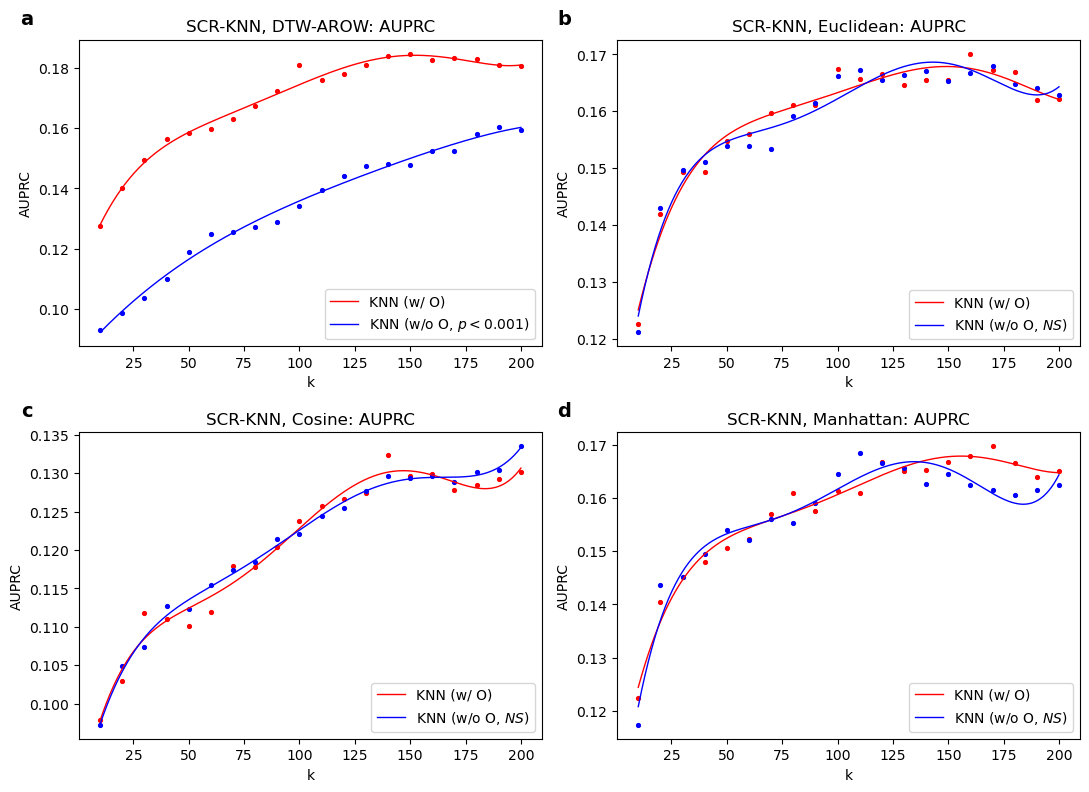

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Imputation_3/SCR-KNN-AUPRC.tif


In [86]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8)) 

metric = "AUPRC"

plot_metric_along_k(axs[0,0], k_sizes_test, SCR_DTW_control_KNN["NW"][metric], SCR_DTW_control_KNN["WT"][metric], "SCR-KNN, DTW-AROW: %s"%(metric), metric, 'KNN')
plot_metric_along_k(axs[0,1], k_sizes_test, SCR_Euc_control_KNN["NW"][metric], SCR_Euc_control_KNN["WT"][metric], "SCR-KNN, Euclidean: %s"%(metric), metric, 'KNN')
plot_metric_along_k(axs[1,0], k_sizes_test, SCR_Cos_control_KNN["NW"][metric], SCR_Cos_control_KNN["WT"][metric], "SCR-KNN, Cosine: %s"%(metric), metric, 'KNN')
plot_metric_along_k(axs[1,1], k_sizes_test, SCR_Manh_control_KNN["NW"][metric], SCR_Manh_control_KNN["WT"][metric], "SCR-KNN, Manhattan: %s"%(metric), metric, 'KNN')
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "SCR-KNN-AUPRC")

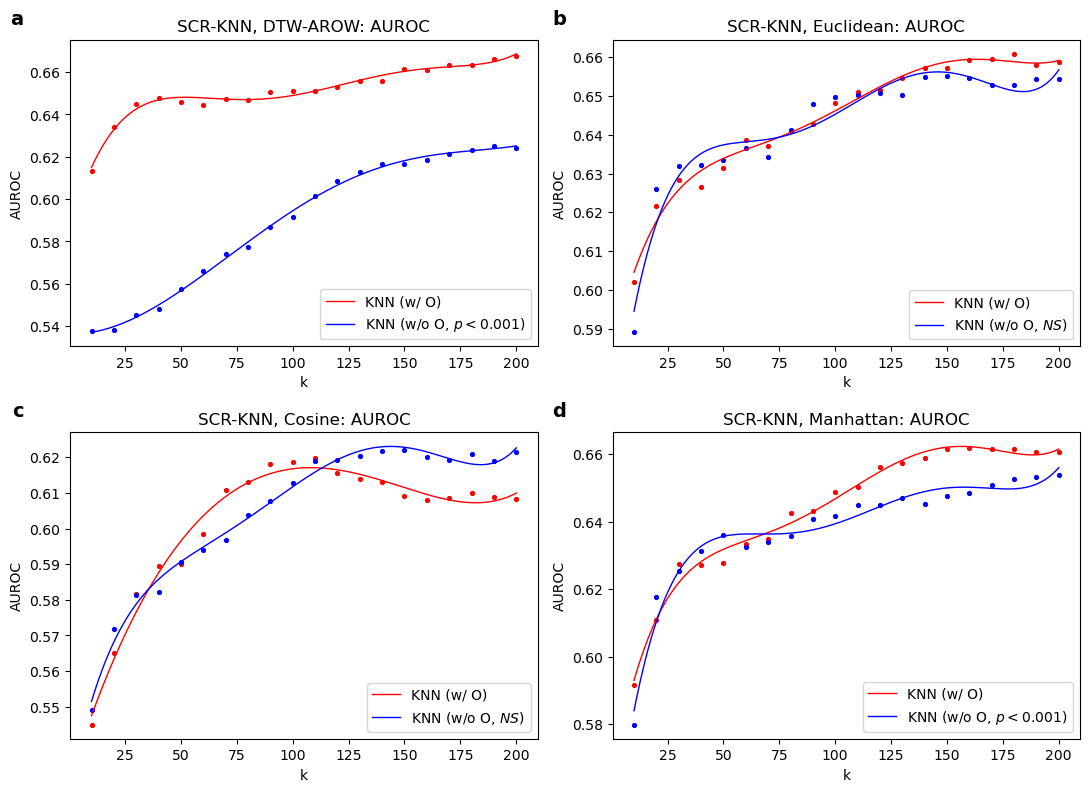

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Imputation_3/SCR-KNN-AUROC.tif


In [87]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8)) 

metric = "AUROC"

plot_metric_along_k(axs[0,0], k_sizes_test, SCR_DTW_control_KNN["NW"][metric], SCR_DTW_control_KNN["WT"][metric], "SCR-KNN, DTW-AROW: %s"%(metric), metric, 'KNN')
plot_metric_along_k(axs[0,1], k_sizes_test, SCR_Euc_control_KNN["NW"][metric], SCR_Euc_control_KNN["WT"][metric], "SCR-KNN, Euclidean: %s"%(metric), metric, 'KNN')
plot_metric_along_k(axs[1,0], k_sizes_test, SCR_Cos_control_KNN["NW"][metric], SCR_Cos_control_KNN["WT"][metric], "SCR-KNN, Cosine: %s"%(metric), metric, 'KNN')
plot_metric_along_k(axs[1,1], k_sizes_test, SCR_Manh_control_KNN["NW"][metric], SCR_Manh_control_KNN["WT"][metric], "SCR-KNN, Manhattan: %s"%(metric), metric, 'KNN')
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "SCR-KNN-AUROC")

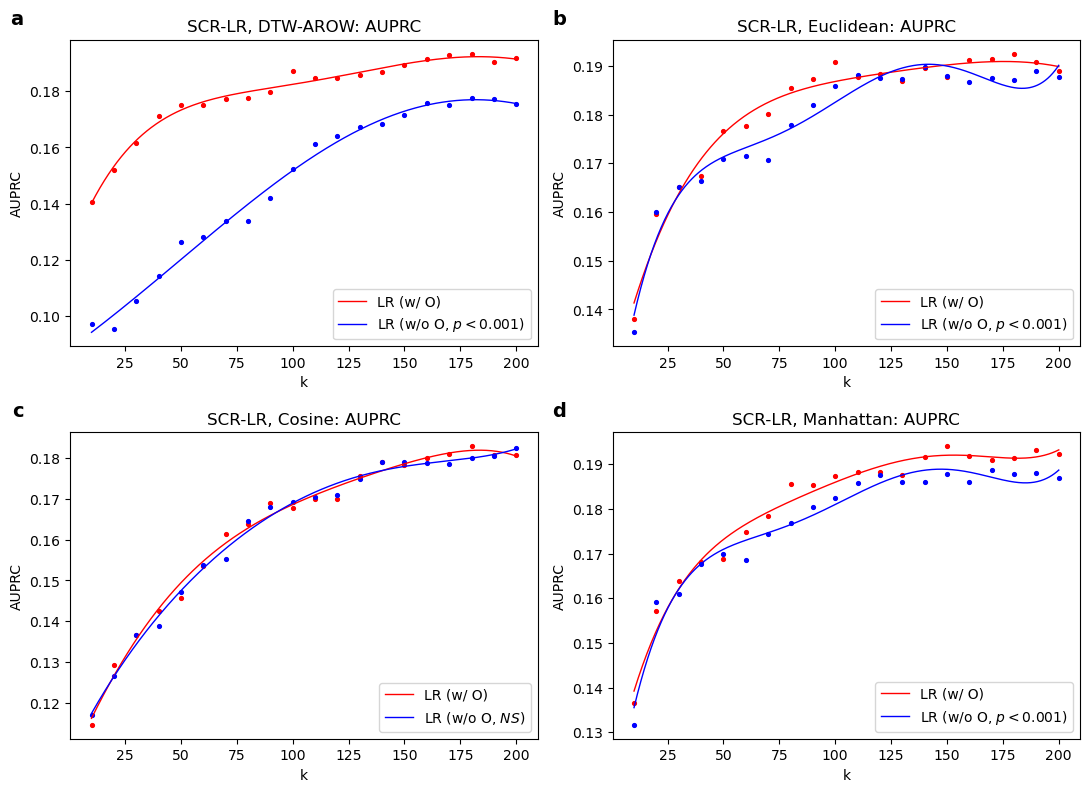

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Imputation_3/SCR-LR-AUPRC.tif


In [88]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8)) 

metric = "AUPRC"

plot_metric_along_k(axs[0,0], k_sizes_test, SCR_DTW_control_LR["NW"][metric], SCR_DTW_control_LR["WT"][metric], "SCR-LR, DTW-AROW: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[0,1], k_sizes_test, SCR_Euc_control_LR["NW"][metric], SCR_Euc_control_LR["WT"][metric], "SCR-LR, Euclidean: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[1,0], k_sizes_test, SCR_Cos_control_LR["NW"][metric], SCR_Cos_control_LR["WT"][metric], "SCR-LR, Cosine: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[1,1], k_sizes_test, SCR_Manh_control_LR["NW"][metric], SCR_Manh_control_LR["WT"][metric], "SCR-LR, Manhattan: %s"%(metric), metric, "LR")
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "SCR-LR-AUPRC")

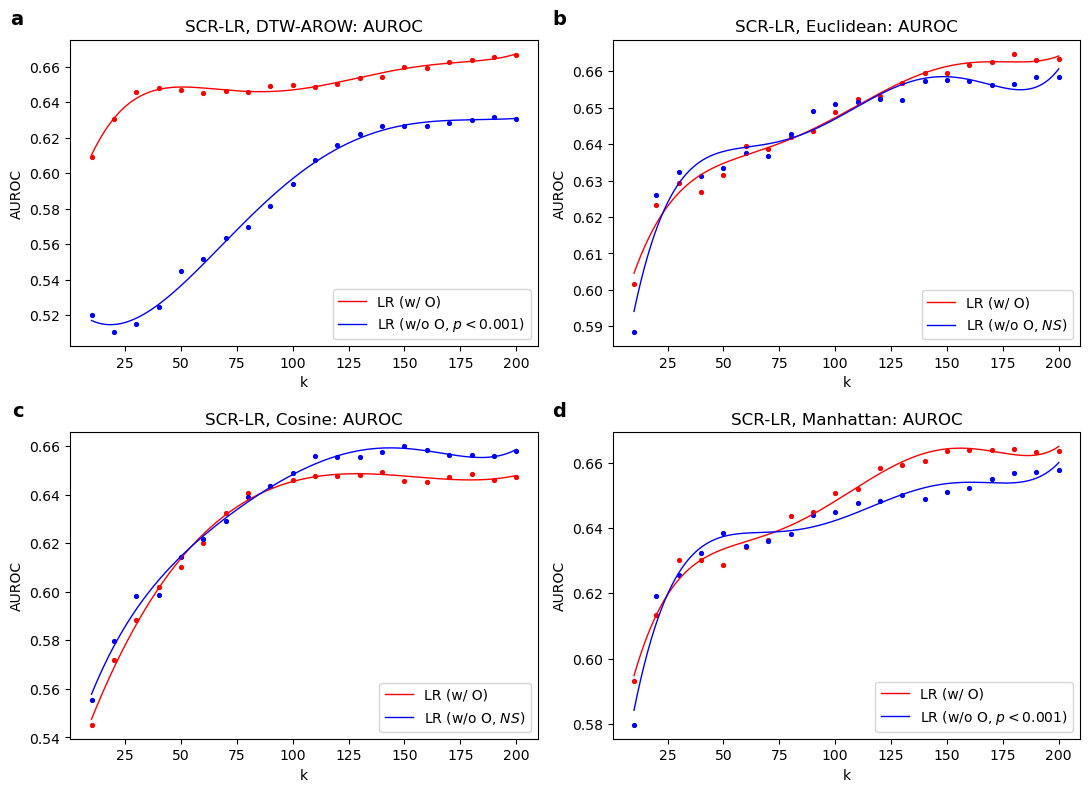

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Imputation_3/SCR-LR-AUROC.tif


In [89]:
fig, axs = plt.subplots(2, 2, figsize=(11, 8)) 

metric = "AUROC"

plot_metric_along_k(axs[0,0], k_sizes_test, SCR_DTW_control_LR["NW"][metric], SCR_DTW_control_LR["WT"][metric], "SCR-LR, DTW-AROW: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[0,1], k_sizes_test, SCR_Euc_control_LR["NW"][metric], SCR_Euc_control_LR["WT"][metric], "SCR-LR, Euclidean: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[1,0], k_sizes_test, SCR_Cos_control_LR["NW"][metric], SCR_Cos_control_LR["WT"][metric], "SCR-LR, Cosine: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[1,1], k_sizes_test, SCR_Manh_control_LR["NW"][metric], SCR_Manh_control_LR["WT"][metric], "SCR-LR, Manhattan: %s"%(metric), metric, "LR")
add_subplot_index(axs, 2, 2)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "SCR-LR-AUROC")

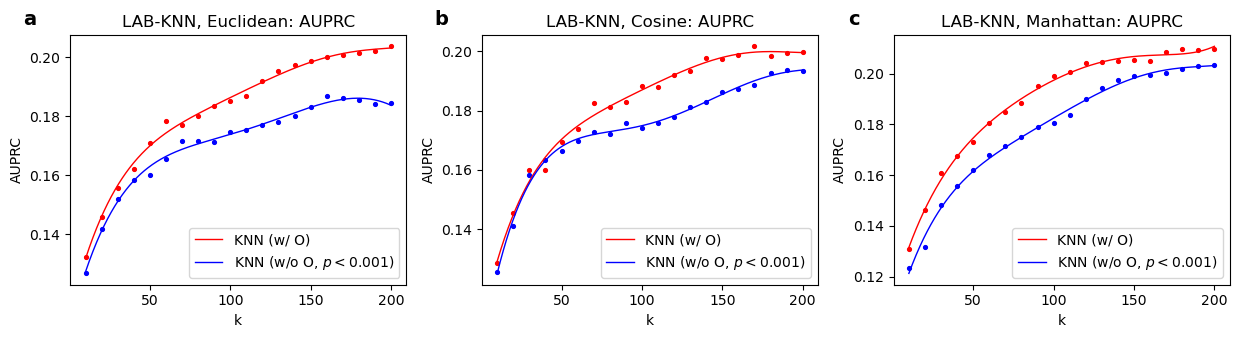

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Imputation_3/LAB-KNN-AUPRC.tif


In [90]:
fig, axs = plt.subplots(1, 3, figsize=(12.5, 3.5)) 

metric = "AUPRC"

plot_metric_along_k(axs[0], k_sizes_test, LAB_Euc_control_KNN["NW"][metric], LAB_Euc_control_KNN["WT"][metric], "LAB-KNN, Euclidean: %s"%(metric), metric, "KNN")
plot_metric_along_k(axs[1], k_sizes_test, LAB_Cos_control_KNN["NW"][metric], LAB_Cos_control_KNN["WT"][metric], "LAB-KNN, Cosine: %s"%(metric), metric, "KNN")
plot_metric_along_k(axs[2], k_sizes_test, LAB_Manh_control_KNN["NW"][metric], LAB_Manh_control_KNN["WT"][metric], "LAB-KNN, Manhattan: %s"%(metric), metric, "KNN")
add_subplot_index(axs, 1, 3)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "LAB-KNN-AUPRC")

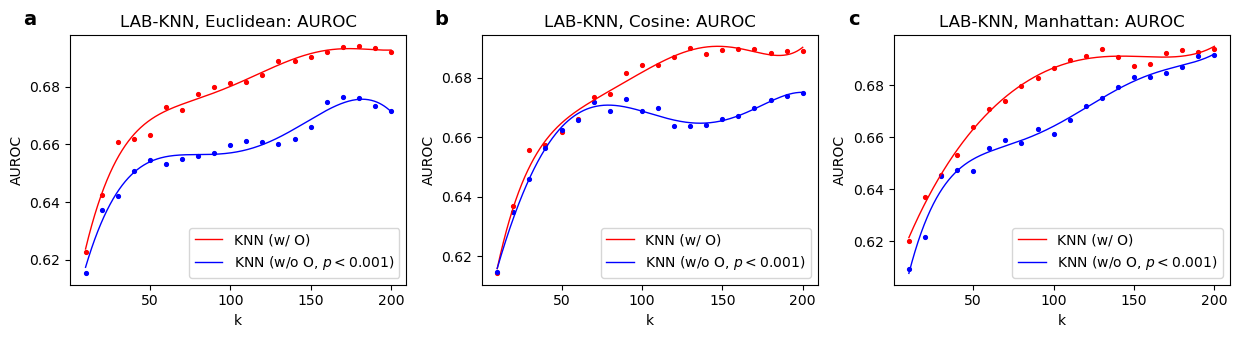

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Imputation_3/LAB-KNN-AUROC.tif


In [91]:
fig, axs = plt.subplots(1, 3, figsize=(12.5, 3.5)) 

metric = "AUROC"

plot_metric_along_k(axs[0], k_sizes_test, LAB_Euc_control_KNN["NW"][metric], LAB_Euc_control_KNN["WT"][metric], "LAB-KNN, Euclidean: %s"%(metric), metric, "KNN")
plot_metric_along_k(axs[1], k_sizes_test, LAB_Cos_control_KNN["NW"][metric], LAB_Cos_control_KNN["WT"][metric], "LAB-KNN, Cosine: %s"%(metric), metric, "KNN")
plot_metric_along_k(axs[2], k_sizes_test, LAB_Manh_control_KNN["NW"][metric], LAB_Manh_control_KNN["WT"][metric], "LAB-KNN, Manhattan: %s"%(metric), metric, "KNN")
add_subplot_index(axs, 1, 3)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "LAB-KNN-AUROC")

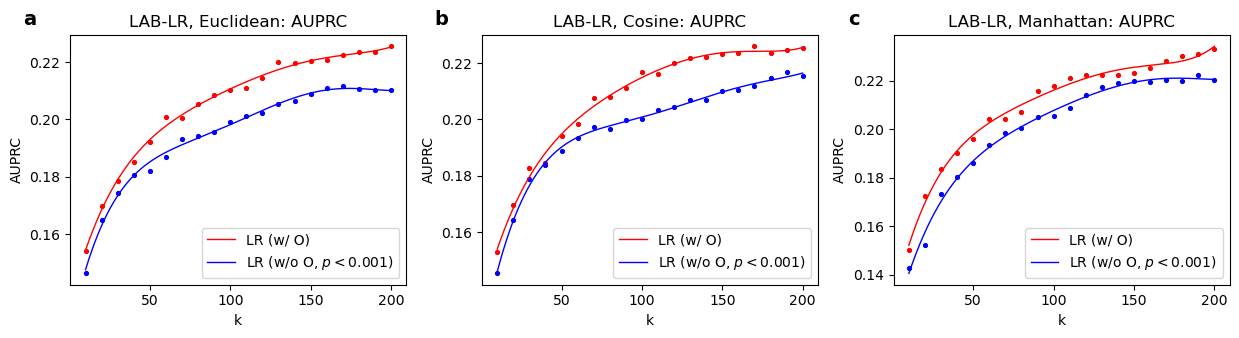

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Imputation_3/LAB-LR-AUPRC.tif


In [92]:
fig, axs = plt.subplots(1, 3, figsize=(12.5, 3.5)) 

metric = "AUPRC"

plot_metric_along_k(axs[0], k_sizes_test, LAB_Euc_control_LR["NW"][metric], LAB_Euc_control_LR["WT"][metric], "LAB-LR, Euclidean: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[1], k_sizes_test, LAB_Cos_control_LR["NW"][metric], LAB_Cos_control_LR["WT"][metric], "LAB-LR, Cosine: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[2], k_sizes_test, LAB_Manh_control_LR["NW"][metric], LAB_Manh_control_LR["WT"][metric], "LAB-LR, Manhattan: %s"%(metric), metric, "LR")
add_subplot_index(axs, 1, 3)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "LAB-LR-AUPRC")

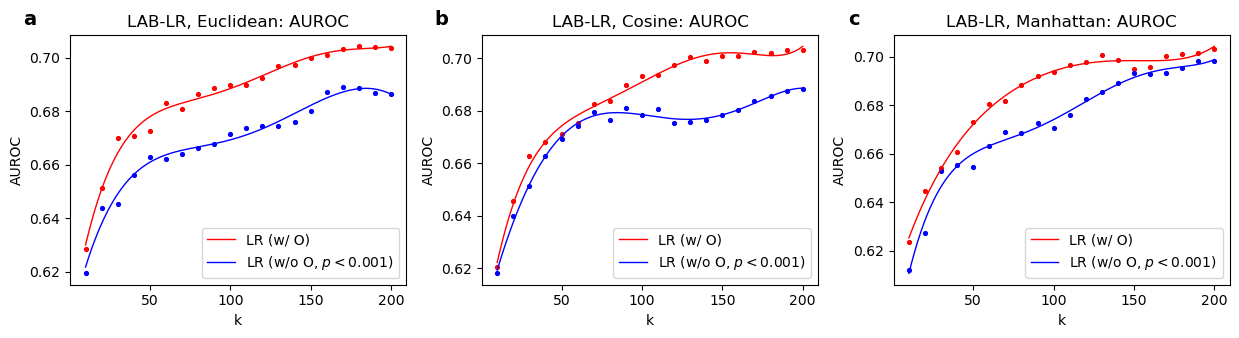

Figure saved at:  /home/lideyi/AKI_SMART/SMART/High_res_figures/Imputation_3/LAB-LR-AUROC.tif


In [93]:
fig, axs = plt.subplots(1, 3, figsize=(12.5, 3.5)) 

metric = "AUROC"

plot_metric_along_k(axs[0], k_sizes_test, LAB_Euc_control_LR["NW"][metric], LAB_Euc_control_LR["WT"][metric], "LAB-LR, Euclidean: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[1], k_sizes_test, LAB_Cos_control_LR["NW"][metric], LAB_Cos_control_LR["WT"][metric], "LAB-LR, Cosine: %s"%(metric), metric, "LR")
plot_metric_along_k(axs[2], k_sizes_test, LAB_Manh_control_LR["NW"][metric], LAB_Manh_control_LR["WT"][metric], "LAB-LR, Manhattan: %s"%(metric), metric, "LR")
add_subplot_index(axs, 1, 3)
plt.tight_layout()
plt.show()
save_figure(fig, figure_folder, "LAB-LR-AUROC")